1. Pratik Antoni Patekar (1001937948)
2. Amrita Singh (1001937490)
3. Ruthvik Kumar Myadam (1002026231)
4. Prathibha Lakkidi (1001962876) 
5. Harshini Kandimalla (1001960046)


#PCA

The dataset used in this example is a preprocessed excerpt of the “Labeled Faces in the Wild”, aka LFW:

http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

In [233]:
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

## Loading the dataset in the numpy array and print the size of the array

In [234]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Split into a training set and a test and keep 25% of the data for testing.

In [235]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

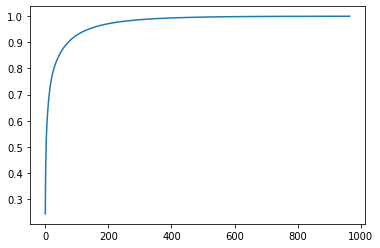

In [236]:
import numpy as np

n_components = 966

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [237]:
import numpy as np

n_components = 150 # as we can see in the plot above that the variance is almost constant after 
# the values of n_components = 150. Therefore we can select the value of n_component as 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True, random_state=2022).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.173s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s


## Train a SVM classification model

In [238]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 5.847s
Best estimator found by grid search:
SVC(C=49281.66607624521, class_weight='balanced', gamma=0.00356790114200059)


## Quantitative evaluation of the model quality on the test set

In [239]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_pred = clf.predict(X_test_pca)
print('Precision, Recall, Confusion matrix, intraining')
print("\nAccuracy:", accuracy_score(y_test,y_pred ))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1 score:", f1_score(y_test, y_pred, average="macro"))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(metrics.classification_report(y_test, y_pred, digits=3))


Precision, Recall, Confusion matrix, intraining

Accuracy: 0.8571428571428571
Precision: 0.8724577609016969
Recall: 0.7600241970104984
F1 score: 0.8018807647135789

Confusion matrix:
[[ 10   1   0   2   0   0   0]
 [  2  54   0   3   0   1   0]
 [  0   3  17   7   0   0   0]
 [  0   5   0 141   0   0   0]
 [  0   2   0   2  20   0   1]
 [  0   4   0   2   0   8   1]
 [  1   3   2   4   0   0  26]]

Classification report:
              precision    recall  f1-score   support

           0      0.769     0.769     0.769        13
           1      0.750     0.900     0.818        60
           2      0.895     0.630     0.739        27
           3      0.876     0.966     0.919       146
           4      1.000     0.800     0.889        25
           5      0.889     0.533     0.667        15
           6      0.929     0.722     0.813        36

    accuracy                          0.857       322
   macro avg      0.872     0.760     0.802       322
weighted avg      0.866     0.857

Predicting people's names on the test set
done in 0.053s
                   precision    recall  f1-score   support

     Ariel Sharon       0.77      0.77      0.77        13
     Colin Powell       0.75      0.90      0.82        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.88      0.97      0.92       146
Gerhard Schroeder       1.00      0.80      0.89        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.93      0.72      0.81        36

         accuracy                           0.86       322
        macro avg       0.87      0.76      0.80       322
     weighted avg       0.87      0.86      0.85       322



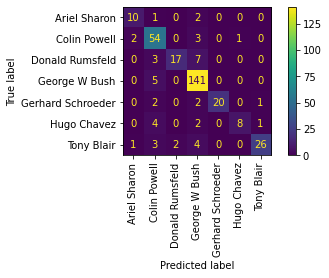

In [240]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Qualitative evaluation of the predictions using matplotlib

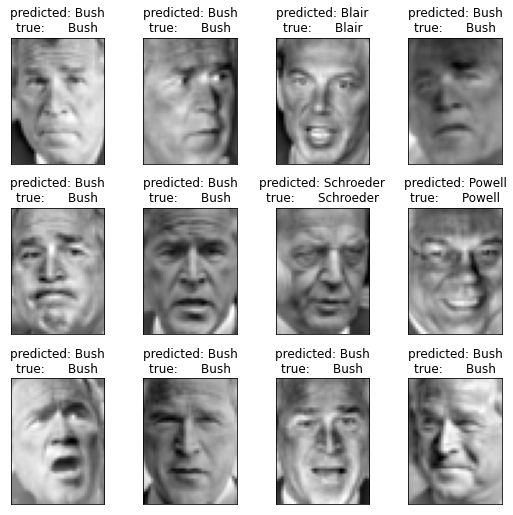

In [241]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

## Plot the gallery of the most significative eigenfaces

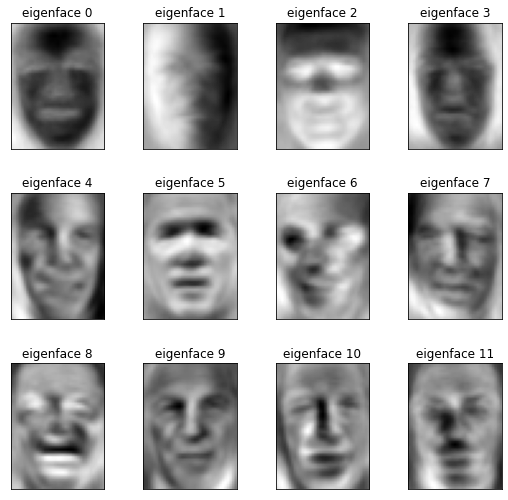

In [242]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

#ICA

Reference link provided on the ICA vs PCA.

https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html

In [243]:
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

## Loading the dataset in the numpy array and print the size of the array

In [244]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Split into a training set and a test and keep 25% of the data for testing

In [245]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Compute a ICA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [246]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
ica = FastICA(n_components=n_components, algorithm ='parallel', whiten="arbitrary-variance",random_state=2022).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = ica.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 3.142s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.033s


## Train a SVM classification model

In [247]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=400
)
clf = clf.fit(X_train_ica, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 204.344s
Best estimator found by grid search:
SVC(C=12708.078504770705, class_weight='balanced', gamma=0.00020615646173794384)


## Quantitative evaluation of the model quality on the test set

Predicting people's names on the test set
done in 0.045s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.76      0.88      0.82        60
  Donald Rumsfeld       0.63      0.70      0.67        27
    George W Bush       0.96      0.82      0.89       146
Gerhard Schroeder       0.67      0.80      0.73        25
      Hugo Chavez       0.56      0.60      0.58        15
       Tony Blair       0.83      0.81      0.82        36

         accuracy                           0.80       322
        macro avg       0.71      0.76      0.73       322
     weighted avg       0.82      0.80      0.81       322



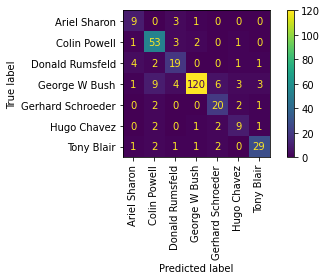

In [248]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_ica)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_ica, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Qualitative evaluation of the predictions using matplotlib

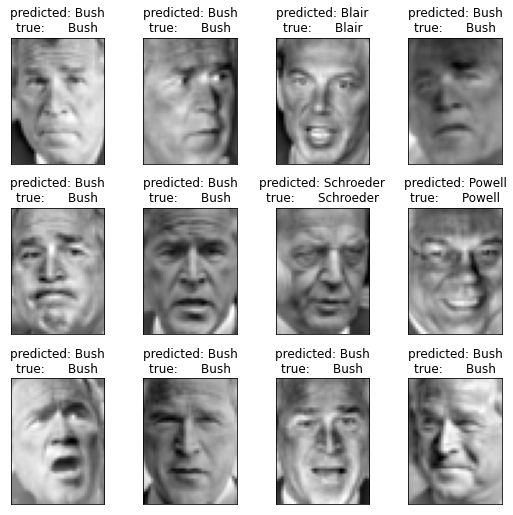

In [249]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

## Plot the gallery of the most significative eigenfaces

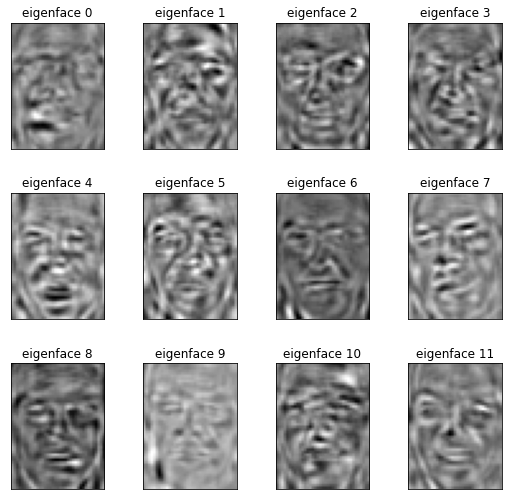

In [250]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()